In [1]:
from optimization.acs import ACS_VRP,ACS_TSP
from optimization.bso import BSO_VRP,BSO_TSP
from optimization.hybrid_acs_bso import ACSBSO_VRP,ACSBSO_TSP
from optimization.ga import GA_VRP
from optimization.sa import SA_VRP
from optimization.tabu_search import TS_VRP
from optimization.dka import DKA_VRP

from optimization.aco import ACO_VRP,ACO_TSP
from optimization.haco import HACO_VRP,HACO_TSP

from optimization.koneksi import ConDB

import sql_connection
import json
import time
import random
import datetime
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import FancyArrowPatch
import networkx as nx

import scipy.stats as stats
from scikit_posthocs import posthoc_dunn

import warnings
warnings.filterwarnings('ignore')

# Generate Data

In [2]:
def generate_data(n = 30, random_state = None):
    random.seed(random_state)
    query = """SELECT 
                    p.post_id,
                    p.post_type,
                    CASE
                        WHEN pj.pj_jam_buka = pj.pj_jam_tutup THEN "tutup"
                        ELSE "buka"
                    END AS is_operate
                FROM 
                    posts p
                LEFT JOIN
                    posts_jadwal pj
                    ON p.post_id = pj.pj_id_tempat AND pj.pj_hari = "minggu"
                """

    df_location = sql_connection.read_from_sql(query)
    
    tourid = df_location[(df_location['post_type']=="location")&
                         (df_location['is_operate'] != "tutup")]['post_id'].values.tolist()
    tourid = random.sample(tourid,n)
    idhotel = df_location[df_location['post_type']=="hotel"]['post_id'].values.tolist()
    idhotel = idhotel[random.randint(0,len(idhotel)-1)]
    
    db = ConDB()

    hotel = db.HotelbyID(idhotel)
    tur = db.WisatabyID(tourid)
    timematrix = db.TimeMatrixbyID(hotel._id,tourid)
    
    return hotel,tur,timematrix

In [3]:
def read_dataset():
    query = """SELECT 
                    p.post_id AS `id`,
                    p.post_long AS `long`,
                    p.post_lat AS `lat`,
                    p.post_type AS `type` 
                FROM 
                    posts p"""
    df_dataset = sql_connection.read_from_sql(query)
    return df_dataset

# Analisis


In [4]:
def find_node(node_id,tour):
    for node in tour:
        if node._id == node_id:
            return node
    return False

def time_to_second(time):
    return (time.hour*3600)+(time.minute*60)+time.second

def diff_second_between_time(time_a,time_b):
    #input: time_a and time_b, datetime.time()
    #output: time_b - time_a, seconds (int)
    return time_to_second(time_b) - time_to_second(time_a)

def get_attribute_analysis(solution):
    days_needed = len(solution)
    poi_included = len(sum([sol["index"] for sol in solution],[]))
    avg_rating = sum(sum([sol["rating"] for sol in solution],[]))/poi_included
    total_tarif = sum(sum([sol["tarif"] for sol in solution],[]))
    total_duration = sum([diff_second_between_time(j[0],j[-1]) for j in [i['waktu'] for i in solution]])
    return days_needed,poi_included,avg_rating,total_tarif,total_duration

def get_analysis(model,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating):
    start = time.time()
    model.set_model(tour=tur,hotel=hotel,timematrix=timematrix,
                    travel_days=travel_days,
                    degree_waktu = dwaktu,degree_tarif = dtarif,degree_rating = drating)
    solution,fitness = model.construct_solution()[-2:]
    end = time.time()
    run_time = end-start
    
    daily_fitness = []
    for day in solution:
        daily_fitness.append(model.MAUT([day],use_penalty=False))
    days_needed,poi_included,avg_rating,total_tarif,total_duration = get_attribute_analysis(solution)
    results = {"solution":[sol["index"] for sol in solution],
               "fitness":fitness,
               "daily_fitness":daily_fitness,
               "days_needed":days_needed,
               "poi_included":poi_included,
               "avg_rating":avg_rating,
               "total_tarif":total_tarif,
               "total_duration":total_duration,
               "run_time":run_time}
    
    return results

In [5]:
def get_detail_node_on_solution(solution):
    db = ConDB()
    node_solution = []
    for i in solution:
        nodes = db.WisatabyID(i)
        node_solution.append(nodes)
    return node_solution

def visualize_solution(solution_node,hotel):
    # Sample VRP data
    vrp_data = [[hotel]+sol+[hotel] for sol in solution_node]
    
    # Generate random node coordinates
    node_coords = {node._id: (float(node.long), float(node.lat)) for node in set(node for route in vrp_data for node in route)}  

    # Number of routes (you can calculate this)
    num_routes = len(vrp_data)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12,9))

    # Define the colors for routes using a colormap
    cmap = plt.get_cmap('tab20', num_routes)

    for i, route in enumerate(vrp_data):
        x = [node_coords[node._id][0] for node in route]
        y = [node_coords[node._id][1] for node in route]
        color = cmap(i)  # Get the color for the route
        # Plot the nodes (scatter plot)
        ax.scatter(x, y, c=color, label=f'Route {i + 1}', s=100)

        for j in range(len(x) - 1):
            # Make the arrow heads larger by increasing mutation_scale
            arrow = FancyArrowPatch(
                (x[j], y[j]), (x[j + 1], y[j + 1]),
                arrowstyle='->', mutation_scale=15, color=color
            )
            ax.add_patch(arrow)

    # Set node 159 (start and end point) to black
    start_x, start_y = node_coords[hotel._id]
    ax.scatter(start_x, start_y, c='k', label='Hotel', s=100)

    # Add labels for nodes
    for node, (x, y) in node_coords.items():
        ax.annotate(str(node), (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Add legend
    ax.legend()

    plt.show()



## Dataset visualization

In [28]:
dataset = read_dataset()

In [39]:
dataset.head()

,id,long,lat,type
0,1,110.365843,-7.792576,POI
1,2,110.365279,-7.798249,POI
2,3,110.362907,-7.813728,POI
3,4,110.363194,-7.811936,POI
4,5,110.365354,-7.795638,POI


In [38]:
dataset['long'] = dataset['long'].astype("float")
dataset['lat'] = dataset['lat'].astype("float")

dataset.loc[dataset['type'] == 'location','type'] = 'POI'

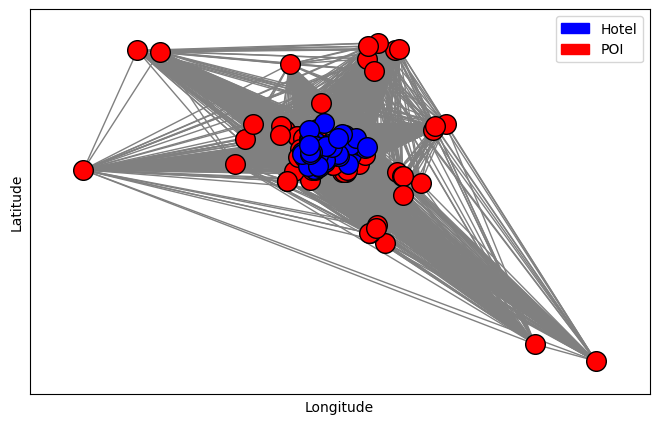

In [50]:
# Create graph
G = nx.Graph()

# Add nodes with types
for idx, row in dataset.iterrows():
    G.add_node(row['id'], pos=(row['long'], row['lat']), type=row['type'])

# Add edges, ensuring that hotels do not connect to other hotels
for i in G.nodes():
    for j in G.nodes():
        if i < j:  # To avoid duplicate edges
            type_i = G.nodes[i]['type']
            type_j = G.nodes[j]['type']
            # Add edge only if at least one of the nodes is not a hotel
            if not (type_i == 'hotel' and type_j == 'hotel'):
                G.add_edge(i, j)


# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Draw nodes and edges with different colors for types
plt.figure(figsize=(8, 5))

# Draw POIs and hotels with different colors
nx.draw_networkx_nodes(G, pos, nodelist=[n for n, d in G.nodes(data=True) if d['type'] == 'POI'], 
                       node_color='red', edgecolors='black', label='POI', node_size=200)
nx.draw_networkx_nodes(G, pos, nodelist=[n for n, d in G.nodes(data=True) if d['type'] == 'hotel'], 
                       node_color='blue', edgecolors='black', label='Hotel', node_size=200)
nx.draw_networkx_edges(G, pos, edge_color='gray')
# nx.draw_networkx_labels(G, pos, labels={n: str(n) for n in G.nodes()})

# Add axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Create legend
hotel_patch = mpatches.Patch(color='blue', label='Hotel')
poi_patch = mpatches.Patch(color='red', label='POI')
plt.legend(handles=[hotel_patch, poi_patch])

# Show plot
plt.axis(True)
plt.show()


In [56]:
import folium

df = dataset.copy()

# Initialize the map centered around the average coordinates
center_lat = df['lat'].mean()
center_long = df['long'].mean()
m = folium.Map(location=[center_lat, center_long], zoom_start=12)

# Add POI markers
for _, row in df[df['type'] == 'POI'].iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=f"POI ID: {row['id']}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Add Hotel markers
for _, row in df[df['type'] == 'hotel'].iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=f"Hotel ID: {row['id']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# Save the map to an HTML file
m.save("map.html")


## 50 random nodes

In [41]:
def result_to_xlsx_rd_nodes(result,random_ls,filename):
    df = pd.DataFrame()
    for method in result:
        res_method = result[method]
        df_method = {
            "random_seed" : random_ls,
            "fitness" : [],
            "fitness_1" : [],
            "fitness_2" : [],
            "fitness_3" : [],
            "poi_included" : [],
            "rating" : [],
            "tarif" : [],
            "total_duration" : [],
            "run_time" : [],
        }
        for res in res_method:
            df_method["fitness"].append(res['fitness'])
            df_method["fitness_1"].append(res['daily_fitness'][0])
            df_method["fitness_2"].append(res['daily_fitness'][1])
            df_method["fitness_3"].append(res['daily_fitness'][2])
            df_method["poi_included"].append(res['poi_included'])
            df_method["rating"].append(res['avg_rating'])
            df_method["tarif"].append(res['total_tarif'])
            df_method["total_duration"].append(res['total_duration'])
            df_method["run_time"].append(res['run_time'])
        df_method = pd.DataFrame(df_method)
        df_method['method'] = method
        df = pd.concat([df,df_method])
    df.to_excel(filename,index=False)

### All DOI 1

In [40]:
len(list(range(5,(5*50)+1,5)))

50

In [110]:
random_ls = list(range(5,(5*50)+1,5))
random_node_analysis ={
    "acsbso_vrp": [],
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("random state = ",random_ls[i])
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acsbso_vrp"].append(results_acsbso_vrp)
    
    ga_vrp = GA_VRP(random_state=100)
    results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ga_vrp"].append(results_ga_vrp)

    ts_vrp = TS_VRP(random_state=100)
    results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ts_vrp"].append(results_ts_vrp)

    sa_vrp = SA_VRP(random_state=100)
    results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["sa_vrp"].append(results_sa_vrp)

random state =  5
random state =  10
random state =  15
random state =  20
random state =  25
random state =  30
random state =  35
random state =  40
random state =  45
random state =  50
random state =  55
random state =  60
random state =  65
random state =  70
random state =  75
random state =  80
random state =  85
random state =  90
random state =  95
random state =  100
random state =  105
random state =  110
random state =  115
random state =  120
random state =  125
random state =  130
random state =  135
random state =  140
random state =  145
random state =  150
random state =  155
random state =  160
random state =  165
random state =  170
random state =  175
random state =  180
random state =  185
random state =  190
random state =  195
random state =  200
random state =  205
random state =  210
random state =  215
random state =  220
random state =  225
random state =  230
random state =  235
random state =  240
random state =  245
random state =  250


In [111]:
random_node_analysis

{'acsbso_vrp': [{'solution': [[90, 52, 99, 66, 55, 93],
    [14, 10, 9, 4, 88, 35, 7, 50, 15, 74],
    [34, 51, 26, 2, 22]],
   'fitness': 0.681778060630262,
   'daily_fitness': [0.6370435883997208,
    0.7053808525506637,
    0.6376004542278128],
   'days_needed': 3,
   'poi_included': 21,
   'avg_rating': 4.604761904761905,
   'total_tarif': 37000,
   'total_duration': 120420,
   'run_time': 10.714658737182617},
  {'solution': [[6, 36, 10, 89, 18, 71, 49],
    [44, 99, 12, 2, 32, 46],
    [34, 39, 74, 66, 57, 22, 21]],
   'fitness': 0.6486284096289016,
   'daily_fitness': [0.5999805391674861,
    0.6423150196656835,
    0.6146307416772019],
   'days_needed': 3,
   'poi_included': 20,
   'avg_rating': 4.574999999999999,
   'total_tarif': 27000,
   'total_duration': 114240,
   'run_time': 25.829691648483276},
  {'solution': [[8, 39, 50, 81, 32, 53, 2],
    [74, 68, 3, 15, 46, 22, 33, 57],
    [20, 85, 71, 93, 43, 36]],
   'fitness': 0.6142148650184502,
   'daily_fitness': [0.5960650447

In [121]:
result_to_xlsx_rd_nodes(random_node_analysis,random_ls,"50_random_nodes_alldoi_1_vrp.xlsx")

In [42]:
random_ls = list(range(5,(5*50)+1,5))
random_node_analysis ={
    "acsbso_vrp": [],
    "acs_vrp": [],
    "bso_vrp": [],
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("random state = ",random_ls[i])
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acsbso_vrp"].append(results_acsbso_vrp)
    
    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acs_vrp"].append(results_acs_vrp)

    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["bso_vrp"].append(results_bso_vrp)

random state =  5
random state =  10
random state =  15
random state =  20
random state =  25
random state =  30
random state =  35
random state =  40
random state =  45
random state =  50
random state =  55
random state =  60
random state =  65
random state =  70
random state =  75
random state =  80
random state =  85
random state =  90
random state =  95
random state =  100
random state =  105
random state =  110
random state =  115
random state =  120
random state =  125
random state =  130
random state =  135
random state =  140
random state =  145
random state =  150
random state =  155
random state =  160
random state =  165
random state =  170
random state =  175
random state =  180
random state =  185
random state =  190
random state =  195
random state =  200
random state =  205
random state =  210
random state =  215
random state =  220
random state =  225
random state =  230
random state =  235
random state =  240
random state =  245
random state =  250


In [43]:
random_node_analysis

{'acsbso_vrp': [{'solution': [[90, 52, 99, 66, 55, 93],
    [14, 10, 9, 4, 88, 35, 7, 50, 15, 74],
    [34, 51, 26, 2, 22]],
   'fitness': 0.681778060630262,
   'daily_fitness': [0.6370435883997208,
    0.7053808525506637,
    0.6376004542278128],
   'days_needed': 3,
   'poi_included': 21,
   'avg_rating': 4.604761904761905,
   'total_tarif': 37000,
   'total_duration': 120420,
   'run_time': 11.111060380935669},
  {'solution': [[6, 36, 10, 89, 18, 71, 49],
    [44, 99, 12, 2, 32, 46],
    [34, 39, 74, 66, 57, 22, 21]],
   'fitness': 0.6486284096289016,
   'daily_fitness': [0.5999805391674861,
    0.6423150196656835,
    0.6146307416772019],
   'days_needed': 3,
   'poi_included': 20,
   'avg_rating': 4.574999999999999,
   'total_tarif': 27000,
   'total_duration': 114240,
   'run_time': 25.619293928146362},
  {'solution': [[8, 39, 50, 81, 32, 53, 2],
    [74, 68, 3, 15, 46, 22, 33, 57],
    [20, 85, 71, 93, 43, 36]],
   'fitness': 0.6142148650184502,
   'daily_fitness': [0.5960650447

In [44]:
result_to_xlsx_rd_nodes(random_node_analysis,random_ls,"50_random_nodes_alldoi_1_vrp_2.xlsx")

In [122]:
random_ls = list(range(5,(5*50)+1,5))
random_node_analysis ={
    "acsbso_tsp": [],
    "acs_tsp": [],
    "bso_tsp": [],
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("random state = ",random_ls[i])
    
    acsbso_tsp = ACSBSO_TSP(random_state=100)
    results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acsbso_tsp"].append(results_acsbso_tsp)
    
    acs_tsp = ACS_TSP(random_state=100)
    results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acs_tsp"].append(results_acs_tsp)

    bso_tsp = BSO_TSP(random_state=100)
    results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["bso_tsp"].append(results_bso_tsp)

random state =  5
random state =  10
random state =  15
random state =  20
random state =  25
random state =  30
random state =  35
random state =  40
random state =  45
random state =  50
random state =  55
random state =  60
random state =  65
random state =  70
random state =  75
random state =  80
random state =  85
random state =  90
random state =  95
random state =  100
random state =  105
random state =  110
random state =  115
random state =  120
random state =  125
random state =  130
random state =  135
random state =  140
random state =  145
random state =  150
random state =  155
random state =  160
random state =  165
random state =  170
random state =  175
random state =  180
random state =  185
random state =  190
random state =  195
random state =  200
random state =  205
random state =  210
random state =  215
random state =  220
random state =  225
random state =  230
random state =  235
random state =  240
random state =  245
random state =  250


In [123]:
random_node_analysis

{'acsbso_tsp': [{'solution': [[2, 7, 10, 50, 15, 4, 35, 88, 52, 93],
    [74, 26, 64, 34, 51],
    [9, 48, 14, 90, 30, 66, 83]],
   'fitness': 0.6350734370257433,
   'daily_fitness': [0.701749213836478, 0.6247794374563241, 0.562168064290706],
   'days_needed': 3,
   'poi_included': 22,
   'avg_rating': 4.572727272727273,
   'total_tarif': 117000,
   'total_duration': 121440,
   'run_time': 45.31474709510803},
  {'solution': [[2, 32, 5, 22, 21],
    [46, 12, 51, 29, 74, 57],
    [10, 89, 48, 71, 49, 36, 66]],
   'fitness': 0.569170399504716,
   'daily_fitness': [0.5726839560799736,
    0.5914741068502132,
    0.5767977126937305],
   'days_needed': 3,
   'poi_included': 18,
   'avg_rating': 4.555555555555555,
   'total_tarif': 110500,
   'total_duration': 119760,
   'run_time': 65.03200387954712},
  {'solution': [[53, 2, 32, 48, 43],
    [74, 57, 38, 31, 64, 3, 36],
    [50, 46, 22, 33, 85, 20, 42]],
   'fitness': 0.5397578187772699,
   'daily_fitness': [0.5463423810259691, 0.52441498543

In [124]:
result_to_xlsx_rd_nodes(random_node_analysis,random_ls,"50_random_nodes_alldoi_1_tsp.xlsx")

### Travel Duration 1, other 0

In [7]:
random_ls = [10,20,30,40,50,60,70,80,90,100]
random_node_analysis ={
    "acsbso_vrp": [],
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
    "dka_vrp": []
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,0,0
    
    print("random state = ",random_ls[i])
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acsbso_vrp"].append(results_acsbso_vrp)
    
    ga_vrp = GA_VRP(random_state=100)
    results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ga_vrp"].append(results_ga_vrp)

    ts_vrp = TS_VRP(random_state=100)
    results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ts_vrp"].append(results_ts_vrp)

    sa_vrp = SA_VRP(random_state=100)
    results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["sa_vrp"].append(results_sa_vrp)
    
    dka_vrp = DKA_VRP(random_state=100)
    results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["dka_vrp"].append(results_dka_vrp)

random state =  10
random state =  20
random state =  30
random state =  40
random state =  50
random state =  60
random state =  70
random state =  80
random state =  90
random state =  100


In [8]:
random_node_analysis

{'acsbso_vrp': [{'solution': [[44, 21, 49, 71, 48, 89, 10, 32],
    [6, 12, 22, 97, 74, 2, 36],
    [57, 80, 66, 67, 99, 18, 5, 46]],
   'fitness': 0.6446759259259259,
   'daily_fitness': [0.4740740740740741,
    0.46412037037037035,
    0.47916666666666663],
   'days_needed': 3,
   'poi_included': 23,
   'avg_rating': 4.534782608695653,
   'total_tarif': 196000,
   'total_duration': 120780,
   'run_time': 27.763322591781616},
  {'solution': [[55, 72, 44, 86, 88, 4, 17, 10, 61],
    [6, 81, 12, 90, 14, 97, 74, 13],
    [80, 28, 36, 21, 67, 45, 43, 23]],
   'fitness': 0.6719135802469136,
   'daily_fitness': [0.4849537037037037,
    0.47430555555555554,
    0.4731481481481481],
   'days_needed': 3,
   'poi_included': 25,
   'avg_rating': 4.548,
   'total_tarif': 321000,
   'total_duration': 125520,
   'run_time': 42.795228242874146},
  {'solution': [[11, 69, 10, 7, 9, 1, 53, 74, 40],
    [95, 72, 18, 88, 35, 4, 86, 46, 22],
    [76, 47, 16, 54, 71, 93, 73]],
   'fitness': 0.6701388888888

### Tarif 1, other 0

In [125]:
random_ls = list(range(5,(5*50)+1,5))
random_node_analysis ={
    "acsbso_vrp": [],
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i])
    travel_days = 3
    dwaktu,dtarif,drating = 0,1,0
    
    print("random state = ",random_ls[i])
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acsbso_vrp"].append(results_acsbso_vrp)
    
    ga_vrp = GA_VRP(random_state=100)
    results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ga_vrp"].append(results_ga_vrp)

    ts_vrp = TS_VRP(random_state=100)
    results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ts_vrp"].append(results_ts_vrp)

    sa_vrp = SA_VRP(random_state=100)
    results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["sa_vrp"].append(results_sa_vrp)

random state =  5
random state =  10
random state =  15
random state =  20
random state =  25
random state =  30
random state =  35
random state =  40
random state =  45
random state =  50
random state =  55
random state =  60
random state =  65
random state =  70
random state =  75
random state =  80
random state =  85
random state =  90
random state =  95
random state =  100
random state =  105
random state =  110
random state =  115
random state =  120
random state =  125
random state =  130
random state =  135
random state =  140
random state =  145
random state =  150
random state =  155
random state =  160
random state =  165
random state =  170
random state =  175
random state =  180
random state =  185
random state =  190
random state =  195
random state =  200
random state =  205
random state =  210
random state =  215
random state =  220
random state =  225
random state =  230
random state =  235
random state =  240
random state =  245
random state =  250


In [126]:
random_node_analysis

{'acsbso_vrp': [{'solution': [[14, 99, 7, 15, 2, 35, 51, 9],
    [93, 90, 55, 22, 26, 83],
    [34, 10, 52, 4, 74, 66, 88, 50]],
   'fitness': 0.8128930817610063,
   'daily_fitness': [0.5814465408805032,
    0.5443396226415095,
    0.6333333333333333],
   'days_needed': 3,
   'poi_included': 22,
   'avg_rating': 4.59090909090909,
   'total_tarif': 57000,
   'total_duration': 130440,
   'run_time': 14.06861662864685},
  {'solution': [[38, 34, 10, 74, 66, 57, 21, 36],
    [44, 18, 12, 39, 32, 89, 49],
    [6, 99, 22, 71, 46, 2]],
   'fitness': 0.8186021659565169,
   'daily_fitness': [0.6191740412979351,
    0.6007374631268436,
    0.5681415929203539],
   'days_needed': 3,
   'poi_included': 21,
   'avg_rating': 4.566666666666667,
   'total_tarif': 35000,
   'total_duration': 130320,
   'run_time': 11.186679124832153},
  {'solution': [[46, 99, 33, 85, 57, 93, 43],
    [8, 22, 39, 74, 50, 32, 36],
    [81, 68, 20, 71, 42, 15, 3, 2]],
   'fitness': 0.8063593554147565,
   'daily_fitness': [0

In [127]:
result_to_xlsx_rd_nodes(random_node_analysis,random_ls,"50_random_nodes_dtarif_1_vrp.xlsx")

### Rating 1, other 0

In [128]:
random_ls = list(range(5,(5*50)+1,5))
random_node_analysis ={
    "acsbso_vrp": [],
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i])
    travel_days = 3
    dwaktu,dtarif,drating = 0,0,1
    
    print("random state = ",random_ls[i])
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acsbso_vrp"].append(results_acsbso_vrp)
    
    ga_vrp = GA_VRP(random_state=100)
    results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ga_vrp"].append(results_ga_vrp)

    ts_vrp = TS_VRP(random_state=100)
    results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ts_vrp"].append(results_ts_vrp)

    sa_vrp = SA_VRP(random_state=100)
    results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["sa_vrp"].append(results_sa_vrp)

random state =  5
random state =  10
random state =  15
random state =  20
random state =  25
random state =  30
random state =  35
random state =  40
random state =  45
random state =  50
random state =  55
random state =  60
random state =  65
random state =  70
random state =  75
random state =  80
random state =  85
random state =  90
random state =  95
random state =  100
random state =  105
random state =  110
random state =  115
random state =  120
random state =  125
random state =  130
random state =  135
random state =  140
random state =  145
random state =  150
random state =  155
random state =  160
random state =  165
random state =  170
random state =  175
random state =  180
random state =  185
random state =  190
random state =  195
random state =  200
random state =  205
random state =  210
random state =  215
random state =  220
random state =  225
random state =  230
random state =  235
random state =  240
random state =  245
random state =  250


In [129]:
random_node_analysis

{'acsbso_vrp': [{'solution': [[88, 50, 52, 22, 35, 2, 7, 93],
    [64, 14, 48, 74, 26, 10, 9, 15],
    [55, 90, 72, 34, 66, 83, 4]],
   'fitness': 0.8275077160493827,
   'daily_fitness': [0.577777777777778,
    0.5222222222222226,
    0.44206349206349216],
   'days_needed': 3,
   'poi_included': 23,
   'avg_rating': 4.6,
   'total_tarif': 169500,
   'total_duration': 129900,
   'run_time': 17.73089838027954},
  {'solution': [[12, 22, 18, 74, 44, 57, 36, 10],
    [39, 64, 51, 71, 49],
    [46, 67, 48, 32, 89, 5, 66, 2, 21]],
   'fitness': 0.7598099046015714,
   'daily_fitness': [0.43333333333333357,
    0.3133333333333333,
    0.4555555555555558],
   'days_needed': 3,
   'poi_included': 22,
   'avg_rating': 4.572727272727273,
   'total_tarif': 141500,
   'total_duration': 132120,
   'run_time': 6.955380916595459},
  {'solution': [[8, 68, 48, 50, 20, 5, 57, 74],
    [46, 2, 81, 3, 93, 53, 36, 15, 85],
    [64, 39, 32, 22, 33, 43]],
   'fitness': 0.751307175446668,
   'daily_fitness': [0.

In [130]:
result_to_xlsx_rd_nodes(random_node_analysis,random_ls,"50_random_nodes_drating_1_vrp.xlsx")

## 87 POIs

In [71]:
def result_to_xlsx(result,n,filename,columns = ["fitness","run_time"]):
    df_result = pd.DataFrame()
    for i in result:
        temp = pd.DataFrame(result[i],columns=columns)
        temp['n'] = n
        temp['method'] = i
        df_result = pd.concat([df_result,temp])
    df_result.to_excel(filename,index=False)

### All DOIs 1

In [15]:
n = list(range(5,87+1,1))
run_time_analysis = {
    "acsbso_vrp": [],
    "acs_vrp": [],
    "bso_vrp": [],
}
max_runtime = 100*60 #100 minutes
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("n = ",i)
    
    if len(run_time_analysis["acsbso_vrp"])==0 or run_time_analysis["acsbso_vrp"][-1][-1] < max_runtime:
        acsbso_vrp = ACSBSO_VRP(random_state=100)
        results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["acsbso_vrp"].append([results_acsbso_vrp[key] for key in ["fitness","run_time"]])
    
    if len(run_time_analysis["acs_vrp"])==0 or run_time_analysis["acs_vrp"][-1][-1] < max_runtime:
        acs_vrp = ACS_VRP(random_state=100)
        results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["acs_vrp"].append([results_acs_vrp[key] for key in ["fitness","run_time"]])
    
    if len(run_time_analysis["bso_vrp"])==0 or run_time_analysis["bso_vrp"][-1][-1] < max_runtime:
        bso_vrp = BSO_VRP(random_state=100)
        results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["bso_vrp"].append([results_bso_vrp[key] for key in ["fitness","run_time"]])

n =  5
n =  6
n =  7
n =  8
n =  9
n =  10
n =  11
n =  12
n =  13
n =  14
n =  15
n =  16
n =  17
n =  18
n =  19
n =  20
n =  21
n =  22
n =  23
n =  24
n =  25
n =  26
n =  27
n =  28
n =  29
n =  30
n =  31
n =  32
n =  33
n =  34
n =  35
n =  36
n =  37
n =  38
n =  39
n =  40
n =  41
n =  42
n =  43
n =  44
n =  45
n =  46
n =  47
n =  48
n =  49
n =  50
n =  51
n =  52
n =  53
n =  54
n =  55
n =  56
n =  57
n =  58
n =  59
n =  60
n =  61
n =  62
n =  63
n =  64
n =  65
n =  66
n =  67
n =  68
n =  69
n =  70
n =  71
n =  72
n =  73
n =  74
n =  75
n =  76
n =  77
n =  78
n =  79
n =  80
n =  81
n =  82
n =  83
n =  84
n =  85
n =  86
n =  87


In [16]:
run_time_analysis

{'acsbso_vrp': [[0.8871090534979426, 0.38937902450561523],
  [0.7119341563786007, 0.5038290023803711],
  [0.6695326278659612, 0.5024936199188232],
  [0.6688786008230453, 0.6986229419708252],
  [0.6744598765432102, 1.366487741470337],
  [0.6521678424456201, 3.1497950553894043],
  [0.6427288760622093, 2.5370266437530518],
  [0.6386610817166373, 5.176518440246582],
  [0.63317731651065, 4.56695818901062],
  [0.6290354413370288, 9.230557203292847],
  [0.6153649113966573, 2.360988140106201],
  [0.6374485596707817, 2.9438838958740234],
  [0.6497466887989763, 2.251497745513916],
  [0.6496729864785421, 6.66308856010437],
  [0.6496314770222577, 6.163872480392456],
  [0.6438124632569079, 5.653172731399536],
  [0.6439741328630216, 7.283833265304565],
  [0.6979500546021015, 4.893263578414917],
  [0.7033054256579555, 12.05141544342041],
  [0.705086939809162, 13.689264297485352],
  [0.7030226563559895, 16.194647073745728],
  [0.7084543028987472, 10.409379243850708],
  [0.7039280421224866, 8.040997266

In [17]:
result_to_xlsx(run_time_analysis,n,"3_various_numbers_pois_all_1_alln.xlsx")

### Travel duration analysis (doi travel duration 1, other 0)

In [64]:
n = [45,50,55,60,65,70,75,80,87]
travel_duration_analysis ={
    "acsbso_vrp": [],
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
}

for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 999
    dwaktu,dtarif,drating = 1,0,0
    
    print("n = ",i)
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acsbso_vrp"].append([results_acsbso_vrp[key] for key in ["total_duration","days_needed"]])

    ga_vrp = GA_VRP(random_state=100)
    results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["ga_vrp"].append([results_ga_vrp[key] for key in ["total_duration","days_needed"]])

    ts_vrp = TS_VRP(random_state=100)
    results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["ts_vrp"].append([results_ts_vrp[key] for key in ["total_duration","days_needed"]])

    sa_vrp = SA_VRP(random_state=100)
    results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["sa_vrp"].append([results_sa_vrp[key] for key in ["total_duration","days_needed"]])

n =  45
n =  50
n =  55
n =  60
n =  65
n =  70
n =  75
n =  80
n =  87


In [65]:
travel_duration_analysis

{'acsbso_vrp': [[285000, 7],
  [318060, 8],
  [342420, 8],
  [363900, 9],
  [399060, 10],
  [420600, 10],
  [447720, 11],
  [489540, 12],
  [534060, 13]],
 'ga_vrp': [[318180, 8],
  [344820, 9],
  [370320, 9],
  [394080, 10],
  [433200, 10],
  [462780, 11],
  [486420, 12],
  [523080, 13],
  [581400, 14]],
 'ts_vrp': [[302340, 8],
  [320400, 8],
  [363180, 9],
  [359100, 9],
  [399900, 10],
  [416700, 11],
  [450060, 11],
  [475200, 12],
  [574680, 14]],
 'sa_vrp': [[340140, 9],
  [377340, 10],
  [388260, 10],
  [402540, 10],
  [465780, 11],
  [484800, 12],
  [525900, 13],
  [535500, 13],
  [647700, 16]]}

In [72]:
result_to_xlsx(travel_duration_analysis,n,"various_numbers_pois_dwaktu_1.xlsx",columns=["total_travel_duration","days_needed"])

### Tarif 1, other 0

In [14]:
n = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,87]
run_time_analysis = {
    "acsbso_vrp": [],
    "acs_vrp": [],
    "bso_vrp": [],
    "acsbso_tsp": []
}
max_runtime = 100*60 #100 minutes
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 0,1,0
    
    print("n = ",i)
    
    if len(run_time_analysis["acsbso_vrp"])==0 or run_time_analysis["acsbso_vrp"][-1][-1] < max_runtime:
        acsbso_vrp = ACSBSO_VRP(random_state=100)
        results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["acsbso_vrp"].append([results_acsbso_vrp[key] for key in ["fitness","run_time"]])
    
    if len(run_time_analysis["acs_vrp"])==0 or run_time_analysis["acs_vrp"][-1][-1] < max_runtime:
        acs_vrp = ACS_VRP(random_state=100)
        results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["acs_vrp"].append([results_acs_vrp[key] for key in ["fitness","run_time"]])
    
    if len(run_time_analysis["bso_vrp"])==0 or run_time_analysis["bso_vrp"][-1][-1] < max_runtime:
        bso_vrp = BSO_VRP(random_state=100)
        results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["bso_vrp"].append([results_bso_vrp[key] for key in ["fitness","run_time"]])
        
    if len(run_time_analysis["acsbso_tsp"])==0 or run_time_analysis["acsbso_tsp"][-1][-1] < max_runtime:
        acsbso_tsp = ACSBSO_TSP(random_state=100)
        results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["acsbso_tsp"].append([results_acsbso_tsp[key] for key in ["fitness","run_time"]])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30
n =  35
n =  40
n =  45
n =  50
n =  55
n =  60
n =  65
n =  70
n =  75
n =  80
n =  87


In [15]:
run_time_analysis

{'acsbso_vrp': [[0.9902777777777778, 0.3689460754394531],
  [0.75, 1.773472547531128],
  [0.8065972222222222, 4.525331258773804],
  [0.8611166225749559, 3.141202926635742],
  [0.8770612874779542, 11.589081048965454],
  [0.8628094293272864, 20.997997283935547],
  [0.8225769068689424, 16.57103443145752],
  [0.7826664462081129, 19.56944513320923],
  [0.7737700983921285, 57.94050621986389],
  [0.7544646271510517, 82.7585916519165],
  [0.747884708541902, 82.52977085113525],
  [0.7293069417456672, 101.2769980430603],
  [0.6776519870020105, 38.02901649475098],
  [0.7144757298324409, 157.71341943740845],
  [0.6971425786135759, 117.84329152107239],
  [0.6629766949152542, 43.898598432540894],
  [0.6839080459770115, 247.17884182929993]],
 'acs_vrp': [[0.9902777777777778, 0.09415245056152344],
  [0.75, 0.2838101387023926],
  [0.7866898148148149, 2.3702392578125],
  [0.8611937830687831, 1.805323839187622],
  [0.8776785714285715, 2.016840934753418],
  [0.8590986394557824, 2.542783737182617],
  [0.80

In [17]:
result_to_xlsx(run_time_analysis,n,"3_various_numbers_pois_dtarif_1.xlsx")

### Rating 1, other 0

In [18]:
n = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,87]
run_time_analysis = {
    "acsbso_vrp": [],
    "acs_vrp": [],
    "bso_vrp": [],
    "acsbso_tsp": []
}
max_runtime = 100*60 #100 minutes
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 0,0,1
    
    print("n = ",i)
    
    if len(run_time_analysis["acsbso_vrp"])==0 or run_time_analysis["acsbso_vrp"][-1][-1] < max_runtime:
        acsbso_vrp = ACSBSO_VRP(random_state=100)
        results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["acsbso_vrp"].append([results_acsbso_vrp[key] for key in ["fitness","run_time"]])
    
    if len(run_time_analysis["acs_vrp"])==0 or run_time_analysis["acs_vrp"][-1][-1] < max_runtime:
        acs_vrp = ACS_VRP(random_state=100)
        results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["acs_vrp"].append([results_acs_vrp[key] for key in ["fitness","run_time"]])
    
    if len(run_time_analysis["bso_vrp"])==0 or run_time_analysis["bso_vrp"][-1][-1] < max_runtime:
        bso_vrp = BSO_VRP(random_state=100)
        results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["bso_vrp"].append([results_bso_vrp[key] for key in ["fitness","run_time"]])
        
    if len(run_time_analysis["acsbso_tsp"])==0 or run_time_analysis["acsbso_tsp"][-1][-1] < max_runtime:
        acsbso_tsp = ACSBSO_TSP(random_state=100)
        results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        run_time_analysis["acsbso_tsp"].append([results_acsbso_tsp[key] for key in ["fitness","run_time"]])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30
n =  35
n =  40
n =  45
n =  50
n =  55
n =  60
n =  65
n =  70
n =  75
n =  80
n =  87


In [19]:
run_time_analysis

{'acsbso_vrp': [[0.8795833333333335, 0.476165771484375],
  [0.8637841710758376, 0.9883723258972168],
  [0.8542603615520283, 4.142903089523315],
  [0.8340225563909776, 6.582834720611572],
  [0.8639510489510489, 9.466446161270142],
  [0.8262820512820512, 17.318251371383667],
  [0.7843336216252883, 22.888553142547607],
  [0.7386900522317187, 22.674569368362427],
  [0.7164036817882968, 38.285372495651245],
  [0.674605887939221, 16.004608631134033],
  [0.6880395466602363, 78.42473554611206],
  [0.6634636582553248, 95.5593192577362],
  [0.6506414349805154, 81.07114362716675],
  [0.6482275788727401, 169.2787516117096],
  [0.6459906759906759, 193.54161262512207],
  [0.6246213774775604, 117.54355430603027],
  [0.6171626186712393, 226.02262139320374]],
 'acs_vrp': [[0.8795833333333335, 0.10995697975158691],
  [0.8638999118165783, 0.4141848087310791],
  [0.8534887566137564, 1.4359488487243652],
  [0.8340225563909776, 0.8985245227813721],
  [0.8613286713286713, 3.403102159500122],
  [0.81309921962

In [21]:
result_to_xlsx(run_time_analysis,n,"3_various_numbers_pois_drating_1.xlsx")

## Uji Statistik

In [20]:
def uji_statistik(first_data,second_data,alternative="greater",first_data_name="first",second_data_name="second"):
    # first_data is the target data, e.g. the results of Hybrid ACS-BSO 
    # second_data is a list of results from other method
    # the test is using Wilcoxon Rank-Sum Test
    second_data_name = ["second" for i in range(len(second_data))] if second_data_name == "second" else second_data_name
    for i in range(len(second_data)):
        statistic, p_value = stats.ranksums(first_data, second_data[i],alternative=alternative)
        print(f"Wilcoxon Rank-Sum Test ({first_data_name} vs. {second_data_name[i]}):")
        print("Test Statistic:", statistic)
        print("p-value:", p_value)
        print("")

### Power Analysis

In [105]:
import numpy as np
from scipy.stats import ranksums

# Parameters for power analysis
alpha = 0.05         # Significance level
effect_size = 0.5    # Desired effect size (e.g., Cohen's d)

# Sample sizes for the two groups
n1 = 50
n2 = 50

# Number of simulations
num_simulations = 1000

# Count of rejections
reject_count = 0

# Perform power analysis through simulation
np.random.seed(42)
for _ in range(num_simulations):
    # Simulate data under the alternative hypothesis with the desired effect size
    group1 = np.random.normal(loc=0, scale=1, size=n1)
    group2 = np.random.normal(loc=effect_size, scale=1, size=n2)
    
    # Perform Wilcoxon rank-sum test
    _, p_value = ranksums(group1, group2)
    
    # Check if null hypothesis is rejected
    if p_value < alpha:
        reject_count += 1

# Calculate power
power = reject_count / num_simulations
print("Power:", power)


Power: 0.7


### General Performance

In [5]:
results_df = pd.read_excel("50_random_nodes_alldoi_1_vrp.xlsx")
results_df.head()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time,method
0,5,0.681778,0.637044,0.705381,0.637600,21,4.604762,37000,120420,10.714659,acsbso_vrp
1,10,0.648628,0.599981,0.642315,0.614631,20,4.575000,27000,114240,25.829692,acsbso_vrp
2,15,0.614215,0.596065,0.600961,0.537402,21,4.633333,81500,122640,13.316754,acsbso_vrp
3,20,0.680889,0.615864,0.684869,0.638814,22,4.595455,37000,119340,19.968890,acsbso_vrp
4,25,0.634522,0.608162,0.621609,0.616015,20,4.565000,68500,120960,18.717250,acsbso_vrp


In [31]:
results_df.groupby('method').mean()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time
method,,,,,,,,,,
acsbso_vrp,127.5,0.663061,0.627354,0.626240,0.619048,22.28,4.574788,57810.0,119944.8,19.771924
ga_vrp,127.5,0.630304,0.620707,0.602557,0.601438,21.02,4.567250,79670.0,126904.8,0.727035
sa_vrp,127.5,0.655173,0.624463,0.620693,0.613879,21.82,4.573416,54910.0,124672.8,0.944255
ts_vrp,127.5,0.640822,0.620363,0.609971,0.611369,21.32,4.571259,68930.0,126156.0,0.656699


In [18]:
metrics = ["fitness","poi_included","rating","tarif","total_duration"]

for metric in metrics:
    print("metric: ",metric)
    metrics = metric
    alternative = "greater" if metric in ["fitness","poi_included","rating"] else "less"
    first_data = results_df[results_df['method']=="acsbso_vrp"][metrics].values
    first_data_name = "acsbso_vrp"

    second_data = []
    second_data_name = []
    for method in results_df[~results_df['method'].isin(["acsbso_vrp","acsbso_tsp"])]['method'].unique():
        second_data.append(results_df[results_df['method']==method][metrics].values)
        second_data_name.append(method)

    uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)

metric:  fitness
Wilcoxon Rank-Sum Test (acsbso_vrp vs. ga_vrp):
Test Statistic: 5.459905341362034
p-value: 2.381942542430321e-08

Wilcoxon Rank-Sum Test (acsbso_vrp vs. ts_vrp):
Test Statistic: 4.191442484277925
p-value: 1.3859323076367846e-05

Wilcoxon Rank-Sum Test (acsbso_vrp vs. sa_vrp):
Test Statistic: 1.8820128259997917
p-value: 0.02991713710157181

metric:  poi_included
Wilcoxon Rank-Sum Test (acsbso_vrp vs. ga_vrp):
Test Statistic: 4.449960729607566
p-value: 4.294299624275932e-06

Wilcoxon Rank-Sum Test (acsbso_vrp vs. ts_vrp):
Test Statistic: 3.4538037576040135
p-value: 0.00027636971661112195

Wilcoxon Rank-Sum Test (acsbso_vrp vs. sa_vrp):
Test Statistic: 1.9509510247543629
p-value: 0.02553143600980818

metric:  rating
Wilcoxon Rank-Sum Test (acsbso_vrp vs. ga_vrp):
Test Statistic: 1.2133122980804518
p-value: 0.1125052213808364

Wilcoxon Rank-Sum Test (acsbso_vrp vs. ts_vrp):
Test Statistic: 0.6032092391024974
p-value: 0.2731847510826574

Wilcoxon Rank-Sum Test (acsbso_vrp v

In [70]:
df_latex = results_df.copy()
df_latex = df_latex.drop(['fitness_1','fitness_2','fitness_3','run_time'],axis=1)
df_latex = df_latex[['method','random_seed','fitness','poi_included','rating','tarif','total_duration']]

df_latex['total_duration'] = df_latex['total_duration']/3600
# df_latex['rating'] = round(df_latex['rating'],2)
# df_latex['fitness'] = round(df_latex['fitness'],4)

df_latex = df_latex.rename(columns={'method':'Method',
                                    'random_seed':'Random Seed',
                                    'fitness':'Fitness',
                                    'poi_included':'The Number of POIs Included',
                                    'rating':'Average Rating',
                                    'tarif':'Total Cost (IDR)',
                                    'total_duration':'Total Travel Duration (Hours)'})

df_latex.loc[df_latex['Method'] == 'acsbso_vrp','Method'] = 'Hybrid ACS-BSO'
df_latex.loc[df_latex['Method'] == 'sa_vrp','Method'] = 'SA'
df_latex.loc[df_latex['Method'] == 'ts_vrp','Method'] = 'TS'
df_latex.loc[df_latex['Method'] == 'ga_vrp','Method'] = 'GA'

df_latex = df_latex.groupby(['Method','Random Seed']).max()

print(df_latex.style.format({'Fitness':'{:.4f}',
                            'Total Travel Duration (Hours)':'{:.2f}',
                             'Average Rating':'{:.2f}'
                            }).to_latex(environment='longtable',
                        clines='all;data',
                        hrules=False,
                        position='H',
                        multirow_align="t",
                        column_format="|l|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|",
                        caption="The Value for each Metrics of 50 Sets of Random POIs for General Performance",
                        label = "tbl:appndx_general_performance"))

\begin{longtable}[H]{|l|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|}
\caption{The Value for each Metrics of 50 Sets of Random POIs for General Performance} \label{tbl:appndx_general_performance} \\
 &  & Fitness & The Number of POIs Included & Average Rating & Total Cost (IDR) & Total Travel Duration (Hours) \\
Method & Random Seed &  &  &  &  &  \\
\endfirsthead
\caption[]{The Value for each Metrics of 50 Sets of Random POIs for General Performance} \\
 &  & Fitness & The Number of POIs Included & Average Rating & Total Cost (IDR) & Total Travel Duration (Hours) \\
Method & Random Seed &  &  &  &  &  \\
\endhead
\multicolumn{7}{r}{Continued on next page} \\
\endfoot
\endlastfoot
\multirow[t]{50}{*}{GA} & 5 & 0.6501 & 20 & 4.61 & 57500 & 35.90 \\
\cline{2-7}
 & 10 & 0.5952 & 21 & 4.56 & 116500 & 34.82 \\
\cline{2-7}
 & 15 & 0.6001 & 20 & 4.63 & 75500 & 36.03 \\
\cline{2-7}
 & 20 & 0.6530 & 19 & 4.61 & 35000 & 33.02 \\
\cline{2-7}
 & 25 & 0.5899 & 19 & 4.55 & 118000 & 36.20 \

### Attribute Analysis

#### Travel Duration

In [73]:
n = np.array([5,10,15,20,25,30,35,40])
acsbso = np.array([24540,62580,90840,119940,150480,173400,213180,245760])/n
ga = np.array([24540,64260,95760,129360,161400,190500,229680,273240])/n
ts = np.array([24540,63660,92220,126360,155100,175620,228360,268140])/n
sa = np.array([27120,69900,109680,134640,171420,196500,251820,286980])/n

In [26]:
first_data = acsbso
second_data = [ga,ts,sa]
alternative = 'less'
uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)

Wilcoxon Rank-Sum Test (acsbso_vrp vs. ga_vrp):
Test Statistic: -2.573014654401468
p-value: 0.005040846941929832

Wilcoxon Rank-Sum Test (acsbso_vrp vs. ts_vrp):
Test Statistic: -1.7328466039846622
p-value: 0.041561468479951666

Wilcoxon Rank-Sum Test (acsbso_vrp vs. sa_vrp):
Test Statistic: -2.6255251575525183
p-value: 0.004325770766973766



In [79]:
td_acsbso = np.array([24540,62580,90840,119940,150480,173400,213180,245760])/3600
td_ga = np.array([24540,64260,95760,129360,161400,190500,229680,273240])/3600
td_ts = np.array([24540,63660,92220,126360,155100,175620,228360,268140])/3600
td_sa = np.array([27120,69900,109680,134640,171420,196500,251820,286980])/3600

dn_acsbso = np.array([1,2,3,3,4,5,5,6])
dn_ga = np.array([1,2,3,4,4,5,6,7])
dn_ts = np.array([1,2,3,4,4,5,6,7])
dn_sa = np.array([1,2,3,4,4,5,6,7])

df_td = pd.DataFrame({
    "N":n,
    "GA":td_ga.round(2),
    "TS":td_ts.round(2),
    "SA":td_sa.round(2),
    "Hybrid ACS-BSO":td_acsbso.round(2)
})

df_dn = pd.DataFrame({
    "N":n,
    "GA":dn_ga,
    "TS":dn_ts,
    "SA":dn_sa,
    "Hybrid ACS-BSO":dn_acsbso
})

In [92]:
df_td_dn_2 = pd.read_excel("various_numbers_pois_dwaktu_1.xlsx")
df_td_dn_2['total_travel_duration'] = df_td_dn_2['total_travel_duration']/3600
df_td_dn_2['total_travel_duration'] = df_td_dn_2['total_travel_duration'].round(2)

df_td_2 = pd.DataFrame({
    "N":df_td_dn_2[df_td_dn_2['method']=='acsbso_vrp']['n'].values,
    "GA":df_td_dn_2[df_td_dn_2['method']=='ga_vrp']['total_travel_duration'].values,
    "TS":df_td_dn_2[df_td_dn_2['method']=='ts_vrp']['total_travel_duration'].values,
    "SA":df_td_dn_2[df_td_dn_2['method']=='sa_vrp']['total_travel_duration'].values,
    "Hybrid ACS-BSO":df_td_dn_2[df_td_dn_2['method']=='acsbso_vrp']['total_travel_duration'].values
})

df_dn_2 = pd.DataFrame({
    "N":df_td_dn_2[df_td_dn_2['method']=='acsbso_vrp']['n'].values,
    "GA":df_td_dn_2[df_td_dn_2['method']=='ga_vrp']['days_needed'].values,
    "TS":df_td_dn_2[df_td_dn_2['method']=='ts_vrp']['days_needed'].values,
    "SA":df_td_dn_2[df_td_dn_2['method']=='sa_vrp']['days_needed'].values,
    "Hybrid ACS-BSO":df_td_dn_2[df_td_dn_2['method']=='acsbso_vrp']['days_needed'].values
})

In [94]:
df_td = pd.concat([df_td,df_td_2])
df_dn = pd.concat([df_dn,df_dn_2])

In [105]:
df_latex = df_td.merge(df_dn,how='inner',on='N')

df_latex = df_latex.set_index('N')
columns = [('Total Travel Duration (hours)','Hybrid ACS-BSO'),
          ('Total Travel Duration (hours)','GA'),
          ('Total Travel Duration (hours)','TS'),
          ('Total Travel Duration (hours)','SA'),
          ('Days Needed','Hybrid ACS-BSO'),
          ('Days Needed','GA'),
          ('Days Needed','TS'),
          ('Days Needed','SA')]
df_latex.columns = pd.MultiIndex.from_tuples(columns)

print(df_latex.style.to_latex(environment='table',
                        hrules=False,
                        multicol_align = "c",
                        position='H',
                        clines="all;data",
                        column_format="|c|m{1.3cm}|c|c|c|m{1.3cm}|c|c|c|",
                        caption="Travel Duration and Days Needed to Visit All POIs (5 to 87 POIs)",
                        label = "tab:appndx_attr_travel_duration"))

\begin{table}[H]
\caption{Travel Duration and Days Needed to Visit All POIs (5 to 87 POIs)}
\label{tab:appndx_attr_travel_duration}
\begin{tabular}{|c|m{1.3cm}|c|c|c|m{1.3cm}|c|c|c|}
 & \multicolumn{4}{c}{Total Travel Duration (hours)} & \multicolumn{4}{c}{Days Needed} \\
 & Hybrid ACS-BSO & GA & TS & SA & Hybrid ACS-BSO & GA & TS & SA \\
N &  &  &  &  &  &  &  &  \\
5 & 6.820000 & 6.820000 & 7.530000 & 6.820000 & 1 & 1 & 1 & 1 \\
\cline{1-9}
10 & 17.850000 & 17.680000 & 19.420000 & 17.380000 & 2 & 2 & 2 & 2 \\
\cline{1-9}
15 & 26.600000 & 25.620000 & 30.470000 & 25.230000 & 3 & 3 & 3 & 3 \\
\cline{1-9}
20 & 35.930000 & 35.100000 & 37.400000 & 33.320000 & 4 & 4 & 4 & 3 \\
\cline{1-9}
25 & 44.830000 & 43.080000 & 47.620000 & 41.800000 & 4 & 4 & 4 & 4 \\
\cline{1-9}
30 & 52.920000 & 48.780000 & 54.580000 & 48.170000 & 5 & 5 & 5 & 5 \\
\cline{1-9}
35 & 63.800000 & 63.430000 & 69.950000 & 59.220000 & 6 & 6 & 6 & 5 \\
\cline{1-9}
40 & 75.900000 & 74.480000 & 79.720000 & 68.270000 & 7 & 7 & 

In [98]:
df_latex

Total Travel Duration (hours)                        
                  Hybrid ACS-BSO      GA      TS      SA
N                                                       
5                           6.82    6.82    7.53    6.82
10                         17.85   17.68   19.42   17.38
15                         26.60   25.62   30.47   25.23
20                         35.93   35.10   37.40   33.32
25                         44.83   43.08   47.62   41.80
30                         52.92   48.78   54.58   48.17
35                         63.80   63.43   69.95   59.22
40                         75.90   74.48   79.72   68.27
45                         88.38   83.98   94.48   79.17
50                         95.78   89.00  104.82   88.35
55                        102.87  100.88  107.85   95.12
60                        109.47   99.75  111.82  101.08
65                        120.33  111.08  129.38  110.85
70                        128.55  115.75  134.67  116.83
75                        135.12  125.02  146.08  124.37
80                        145.30  132.00  148.75  135.98
87                        161.50  159.63  179.92  148.35

In [95]:
df_td

,N,GA,TS,SA,Hybrid ACS-BSO
0,5,6.82,6.82,7.53,6.82
1,10,17.85,17.68,19.42,17.38
2,15,26.60,25.62,30.47,25.23
3,20,35.93,35.10,37.40,33.32
4,25,44.83,43.08,47.62,41.80
5,30,52.92,48.78,54.58,48.17
6,35,63.80,63.43,69.95,59.22
7,40,75.90,74.48,79.72,68.27
0,45,88.38,83.98,94.48,79.17
1,50,95.78,89.00,104.82,88.35


In [96]:
df_dn

,N,GA,TS,SA,Hybrid ACS-BSO
0,5,1,1,1,1
1,10,2,2,2,2
2,15,3,3,3,3
3,20,4,4,4,3
4,25,4,4,4,4
5,30,5,5,5,5
6,35,6,6,6,5
7,40,7,7,7,6
0,45,8,8,9,7
1,50,9,8,10,8


#### Tarif

In [75]:
results_df = pd.read_excel("50_random_nodes_dtarif_1_vrp.xlsx")
results_df.head()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time,method
0,5,0.812893,0.581447,0.544340,0.633333,22,4.590909,57000,130440,14.068617,acsbso_vrp
1,10,0.818602,0.619174,0.600737,0.568142,21,4.566667,35000,130320,11.186679,acsbso_vrp
2,15,0.806359,0.564511,0.604149,0.577701,22,4.595455,86500,132240,16.528855,acsbso_vrp
3,20,0.847439,0.569773,0.599328,0.642443,23,4.595652,57000,131880,15.483165,acsbso_vrp
4,25,0.791134,0.601364,0.546888,0.600682,20,4.580000,66000,132900,20.183995,acsbso_vrp


In [33]:
results_df.groupby('method').mean()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time
method,,,,,,,,,,
acsbso_vrp,127.5,0.830427,0.604457,0.593020,0.588170,22.56,4.562295,61340.0,131040.0,14.487001
ga_vrp,127.5,0.794451,0.584935,0.573823,0.577585,21.28,4.555451,79340.0,129303.6,0.737736
sa_vrp,127.5,0.823688,0.602343,0.589186,0.586356,22.20,4.560042,61820.0,130809.6,0.949543
ts_vrp,127.5,0.805346,0.595846,0.584381,0.573113,21.62,4.558677,71100.0,128365.2,0.667012


In [28]:
metrics = ["fitness","poi_included","tarif"]

for metric in metrics:
    print("metric: ",metric)
    metrics = metric
    alternative = "greater" if metric in ["fitness","poi_included","rating"] else "less"
    first_data = results_df[results_df['method']=="acsbso_vrp"][metrics].values
    first_data_name = "acsbso_vrp"

    second_data = []
    second_data_name = []
    for method in results_df[~results_df['method'].isin(["acsbso_vrp","acsbso_tsp"])]['method'].unique():
        second_data.append(results_df[results_df['method']==method][metrics].values)
        second_data_name.append(method)

    uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)

metric:  fitness
Wilcoxon Rank-Sum Test (acsbso_vrp vs. ga_vrp):
Test Statistic: 6.356101925171458
p-value: 1.034688727511731e-10

Wilcoxon Rank-Sum Test (acsbso_vrp vs. ts_vrp):
Test Statistic: 4.970444130204578
p-value: 3.339985434056978e-07

Wilcoxon Rank-Sum Test (acsbso_vrp vs. sa_vrp):
Test Statistic: 1.3718701552159656
p-value: 0.08505193134758504

metric:  poi_included
Wilcoxon Rank-Sum Test (acsbso_vrp vs. ga_vrp):
Test Statistic: 4.243146133343853
p-value: 1.1020390332711966e-05

Wilcoxon Rank-Sum Test (acsbso_vrp vs. ts_vrp):
Test Statistic: 3.1746040526480006
p-value: 0.0007502054238140426

Wilcoxon Rank-Sum Test (acsbso_vrp vs. sa_vrp):
Test Statistic: 1.2305468477690946
p-value: 0.1092461975870278

metric:  tarif
Wilcoxon Rank-Sum Test (acsbso_vrp vs. ga_vrp):
Test Statistic: -2.9091919874429015
p-value: 0.0018118212857961447

Wilcoxon Rank-Sum Test (acsbso_vrp vs. ts_vrp):
Test Statistic: -1.9785263042561914
p-value: 0.023934682083350964

Wilcoxon Rank-Sum Test (acsbso_v

In [76]:
df_latex = results_df.copy()
df_latex = df_latex[['method','random_seed','fitness','tarif']]

df_latex = df_latex.rename(columns={'method':'Method',
                                    'random_seed':'Random Seed',
                                    'fitness':'Fitness',
                                    'tarif':'Total Cost (IDR)',
                                    })

df_latex.loc[df_latex['Method'] == 'acsbso_vrp','Method'] = 'Hybrid ACS-BSO'
df_latex.loc[df_latex['Method'] == 'sa_vrp','Method'] = 'SA'
df_latex.loc[df_latex['Method'] == 'ts_vrp','Method'] = 'TS'
df_latex.loc[df_latex['Method'] == 'ga_vrp','Method'] = 'GA'

df_latex = df_latex.groupby(['Method','Random Seed']).max()

print(df_latex.style.format({'Fitness':'{:.4f}'}).to_latex(environment='longtable',
                        clines='all;data',
                        hrules=False,
                        position='H',
                        multirow_align="t",
                        column_format="|l|m{1.5cm}|m{1.5cm}|m{1.5cm}|",
                        caption="The Value for each Metrics of 50 Sets of Random POIs for Cost Attribute Analysis",
                        label = "tbl:appndx_attr_cost"))

\begin{longtable}[H]{|l|m{1.5cm}|m{1.5cm}|m{1.5cm}|}
\caption{The Value for each Metrics of 50 Sets of Random POIs for Cost Attribute Analysis} \label{tbl:appndx_attr_cost} \\
 &  & Fitness & Total Cost (IDR) \\
Method & Random Seed &  &  \\
\endfirsthead
\caption[]{The Value for each Metrics of 50 Sets of Random POIs for Cost Attribute Analysis} \\
 &  & Fitness & Total Cost (IDR) \\
Method & Random Seed &  &  \\
\endhead
\multicolumn{4}{r}{Continued on next page} \\
\endfoot
\endlastfoot
\multirow[t]{50}{*}{GA} & 5 & 0.8013 & 33000 \\
\cline{2-4}
 & 10 & 0.7572 & 63500 \\
\cline{2-4}
 & 15 & 0.7447 & 125500 \\
\cline{2-4}
 & 20 & 0.7993 & 107000 \\
\cline{2-4}
 & 25 & 0.7641 & 81000 \\
\cline{2-4}
 & 30 & 0.8203 & 34000 \\
\cline{2-4}
 & 35 & 0.7956 & 72000 \\
\cline{2-4}
 & 40 & 0.8110 & 109000 \\
\cline{2-4}
 & 45 & 0.7717 & 91000 \\
\cline{2-4}
 & 50 & 0.8413 & 27000 \\
\cline{2-4}
 & 55 & 0.8130 & 82000 \\
\cline{2-4}
 & 60 & 0.8114 & 75000 \\
\cline{2-4}
 & 65 & 0.8018 & 69500 \

#### Rating

In [77]:
results_df = pd.read_excel("50_random_nodes_drating_1_vrp.xlsx")
results_df.head()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time,method
0,5,0.827508,0.577778,0.522222,0.442063,23,4.600000,169500,129900,17.730898,acsbso_vrp
1,10,0.759810,0.433333,0.313333,0.455556,22,4.572727,141500,132120,6.955381,acsbso_vrp
2,15,0.751307,0.374405,0.403968,0.302381,23,4.630435,166500,133860,14.632515,acsbso_vrp
3,20,0.809722,0.539583,0.437037,0.378571,24,4.583333,265000,131700,19.194298,acsbso_vrp
4,25,0.781362,0.428355,0.395887,0.447980,23,4.552174,173500,130560,21.931605,acsbso_vrp


In [36]:
results_df.groupby('method').mean()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time
method,,,,,,,,,,
acsbso_vrp,127.5,0.803109,0.470304,0.449456,0.420703,23.70,4.589172,183390.0,131845.2,15.240533
ga_vrp,127.5,0.776126,0.433778,0.426877,0.428268,22.46,4.571522,192850.0,130124.4,0.693261
sa_vrp,127.5,0.793384,0.445789,0.438588,0.433978,23.32,4.579160,196370.0,131580.0,0.954392
ts_vrp,127.5,0.785149,0.444094,0.429917,0.427619,22.94,4.573304,185080.0,131137.2,0.669594


In [37]:
metrics = ["fitness","poi_included","rating"]

for metric in metrics:
    print("metric: ",metric)
    metrics = metric
    alternative = "greater" if metric in ["fitness","poi_included","rating"] else "less"
    first_data = results_df[results_df['method']=="acsbso_vrp"][metrics].values
    first_data_name = "acsbso_vrp"

    second_data = []
    second_data_name = []
    for method in results_df[~results_df['method'].isin(["acsbso_vrp","acsbso_tsp"])]['method'].unique():
        second_data.append(results_df[results_df['method']==method][metrics].values)
        second_data_name.append(method)

    uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)

metric:  fitness
Wilcoxon Rank-Sum Test (acsbso_vrp vs. ga_vrp):
Test Statistic: 3.8329638507541546
p-value: 6.33042821804192e-05

Wilcoxon Rank-Sum Test (acsbso_vrp vs. ts_vrp):
Test Statistic: 2.495562794915475
p-value: 0.006287874720824638

Wilcoxon Rank-Sum Test (acsbso_vrp vs. sa_vrp):
Test Statistic: 1.382210885029151
p-value: 0.08345347942734727

metric:  poi_included
Wilcoxon Rank-Sum Test (acsbso_vrp vs. ga_vrp):
Test Statistic: 4.5154520184244085
p-value: 3.159092580063381e-06

Wilcoxon Rank-Sum Test (acsbso_vrp vs. ts_vrp):
Test Statistic: 2.8850636178788016
p-value: 0.0019566728660068626

Wilcoxon Rank-Sum Test (acsbso_vrp vs. sa_vrp):
Test Statistic: 1.3925516148423367
p-value: 0.08187771159029067

metric:  rating
Wilcoxon Rank-Sum Test (acsbso_vrp vs. ga_vrp):
Test Statistic: 2.7471872203696592
p-value: 0.003005440569544777

Wilcoxon Rank-Sum Test (acsbso_vrp vs. ts_vrp):
Test Statistic: 2.392155496783618
p-value: 0.008374872179099048

Wilcoxon Rank-Sum Test (acsbso_vrp v

In [78]:
df_latex = results_df.copy()
df_latex = df_latex[['method','random_seed','fitness','rating']]

df_latex = df_latex.rename(columns={'method':'Method',
                                    'random_seed':'Random Seed',
                                    'fitness':'Fitness',
                                    'rating':'Average Rating',
                                    })

df_latex.loc[df_latex['Method'] == 'acsbso_vrp','Method'] = 'Hybrid ACS-BSO'
df_latex.loc[df_latex['Method'] == 'sa_vrp','Method'] = 'SA'
df_latex.loc[df_latex['Method'] == 'ts_vrp','Method'] = 'TS'
df_latex.loc[df_latex['Method'] == 'ga_vrp','Method'] = 'GA'

df_latex = df_latex.groupby(['Method','Random Seed']).max()

print(df_latex.style.format({'Fitness':'{:.4f}',
                            'Average Rating':'{:.2f}'}).to_latex(environment='longtable',
                        clines='all;data',
                        hrules=False,
                        position='H',
                        multirow_align="t",
                        column_format="|c|m{1.5cm}|m{1.5cm}|m{1.5cm}|",
                        caption="The Value for each Metrics of 50 Sets of Random POIs for Rating Attribute Analysis",
                        label = "tbl:appndx_attr_rating"))

\begin{longtable}[H]{|c|m{1.5cm}|m{1.5cm}|m{1.5cm}|}
\caption{The Value for each Metrics of 50 Sets of Random POIs for Rating Attribute Analysis} \label{tbl:appndx_attr_rating} \\
 &  & Fitness & Average Rating \\
Method & Random Seed &  &  \\
\endfirsthead
\caption[]{The Value for each Metrics of 50 Sets of Random POIs for Rating Attribute Analysis} \\
 &  & Fitness & Average Rating \\
Method & Random Seed &  &  \\
\endhead
\multicolumn{4}{r}{Continued on next page} \\
\endfoot
\endlastfoot
\multirow[t]{50}{*}{GA} & 5 & 0.7952 & 4.55 \\
\cline{2-4}
 & 10 & 0.7385 & 4.56 \\
\cline{2-4}
 & 15 & 0.7105 & 4.61 \\
\cline{2-4}
 & 20 & 0.7859 & 4.57 \\
\cline{2-4}
 & 25 & 0.7548 & 4.51 \\
\cline{2-4}
 & 30 & 0.8088 & 4.62 \\
\cline{2-4}
 & 35 & 0.7886 & 4.62 \\
\cline{2-4}
 & 40 & 0.7680 & 4.57 \\
\cline{2-4}
 & 45 & 0.7914 & 4.60 \\
\cline{2-4}
 & 50 & 0.7884 & 4.62 \\
\cline{2-4}
 & 55 & 0.7991 & 4.58 \\
\cline{2-4}
 & 60 & 0.7972 & 4.60 \\
\cline{2-4}
 & 65 & 0.6900 & 4.55 \\
\cline{2-4}


### Hybrid vs Standalone

In [5]:
all_1_df = pd.read_excel("3_various_numbers_pois_all_1_alln.xlsx")
# all_1_df = all_1_df[all_1_df['n']>=5]
# waktu_1_df = pd.read_excel("3_various_numbers_pois_dwaktu_1.xlsx")
# tarif_1_df = pd.read_excel("3_various_numbers_pois_dtarif_1.xlsx")
# rating_1_df = pd.read_excel("3_various_numbers_pois_drating_1.xlsx")

In [63]:
metrics = ["fitness"]

for metric in metrics:
    print("metric: ",metric)
    metrics = metric
    alternative = "greater" if metric in ["fitness","poi_included","rating"] else "less"
    first_data = all_1_df[all_1_df['method']=="acsbso_vrp"][metrics].values
    first_data_name = "acsbso_vrp"

    second_data = []
    second_data_name = []
    for method in all_1_df[~all_1_df['method'].isin(["acsbso_vrp","acsbso_tsp"])]['method'].unique():
        second_data.append(all_1_df[all_1_df['method']==method][metrics].values)
        second_data_name.append(method)

    uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)

metric:  fitness
Wilcoxon Rank-Sum Test (acsbso_vrp vs. acs_vrp):
Test Statistic: 1.3822864922064122
p-value: 0.0834418759251696

Wilcoxon Rank-Sum Test (acsbso_vrp vs. bso_vrp):
Test Statistic: 8.182296327114358
p-value: 1.3924259627017884e-16



In [38]:
df_latex = all_1_df[['n']].drop_duplicates().sort_values('n',ascending=True).copy()
df_latex.columns = ['N']
df_latex['f_acsbso_vrp'] = all_1_df[all_1_df['method']=='acsbso_vrp'].sort_values('n')['fitness'].values
df_latex['f_acs_vrp'] = all_1_df[all_1_df['method']=='acs_vrp'].sort_values('n')['fitness'].values
df_latex['f_bso_vrp'] = all_1_df[all_1_df['method']=='bso_vrp'].sort_values('n')['fitness'].values
df_latex['r_acsbso_vrp'] = all_1_df[all_1_df['method']=='acsbso_vrp'].sort_values('n')['run_time'].values
df_latex['r_acs_vrp'] = all_1_df[all_1_df['method']=='acs_vrp'].sort_values('n')['run_time'].values
df_latex['r_bso_vrp'] = all_1_df[all_1_df['method']=='bso_vrp'].sort_values('n')['run_time'].values

df_latex = df_latex.set_index('N')
columns = [('Fitness','Hybrid ACS-BSO'),
          ('Fitness','ACS'),
          ('Fitness','BSO'),
          ('Running Time','Hybrid ACS-BSO'),
          ('Running Time','ACS'),
          ('Running Time','BSO')]
df_latex.columns = pd.MultiIndex.from_tuples(columns)

print(df_latex.style.to_latex(environment='longtable',
                        hrules=False,
                        multicol_align = "c",
                        position='H',
                        clines="all;data",
                        column_format="|c|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|",
                        caption="Fitness Values and Running Times Over Various Numbers of POIs",
                        label = "tab:appndx_hybrid_vs_standalone"))

\begin{longtable}[H]{|c|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|}
\caption{Fitness Values and Running Times Over Various Numbers of POIs} \label{tab:appndx_hybrid_vs_standalone} \\
 & \multicolumn{3}{c}{Fitness} & \multicolumn{3}{c}{Running Time} \\
 & Hybrid ACS-BSO & ACS & BSO & Hybrid ACS-BSO & ACS & BSO \\
N &  &  &  &  &  &  \\
\endfirsthead
\caption[]{Fitness Values and Running Times Over Various Numbers of POIs} \\
 & \multicolumn{3}{c}{Fitness} & \multicolumn{3}{c}{Running Time} \\
 & Hybrid ACS-BSO & ACS & BSO & Hybrid ACS-BSO & ACS & BSO \\
N &  &  &  &  &  &  \\
\endhead
\multicolumn{7}{r}{Continued on next page} \\
\endfoot
\endlastfoot
5 & 0.887109 & 0.887109 & 0.886749 & 0.389379 & 0.125616 & 0.027912 \\
\cline{1-7}
6 & 0.711934 & 0.711934 & 0.711831 & 0.503829 & 0.182309 & 0.039527 \\
\cline{1-7}
7 & 0.669533 & 0.669584 & 0.669327 & 0.502494 & 0.350735 & 0.031253 \\
\cline{1-7}
8 & 0.668879 & 0.668879 & 0.668570 & 0.698623 & 0.261957 & 0.053148 \\
\cline{1-

## VRP vs TSP

In [39]:
results_vrp = pd.read_excel("50_random_nodes_alldoi_1_vrp_2.xlsx")
results_vrp.head()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time,method
0,5,0.681778,0.637044,0.705381,0.637600,21,4.604762,37000,120420,11.111060,acsbso_vrp
1,10,0.648628,0.599981,0.642315,0.614631,20,4.575000,27000,114240,25.619294,acsbso_vrp
2,15,0.614215,0.596065,0.600961,0.537402,21,4.633333,81500,122640,13.256881,acsbso_vrp
3,20,0.680889,0.615864,0.684869,0.638814,22,4.595455,37000,119340,20.029216,acsbso_vrp
4,25,0.634522,0.608162,0.621609,0.616015,20,4.565000,68500,120960,18.848519,acsbso_vrp


In [53]:
results_vrp.groupby('method').mean()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time
method,,,,,,,,,,
acs_vrp,127.5,0.655696,0.637008,0.621101,0.605848,21.88,4.581554,59730.0,123607.2,3.802153
acsbso_vrp,127.5,0.663061,0.627354,0.626240,0.619048,22.28,4.574788,57810.0,119944.8,19.697478
bso_vrp,127.5,0.550465,0.566040,0.573433,0.567408,19.56,4.545299,203030.0,123819.6,0.369207


In [40]:
results_tsp = pd.read_excel("50_random_nodes_alldoi_1_tsp.xlsx")
results_tsp.head()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time,method
0,5,0.635073,0.701749,0.624779,0.562168,22,4.572727,117000,121440,45.314747,acsbso_tsp
1,10,0.569170,0.572684,0.591474,0.576798,18,4.555556,110500,119760,65.032004,acsbso_tsp
2,15,0.539758,0.546342,0.524415,0.554215,19,4.605263,163000,130980,45.532017,acsbso_tsp
3,20,0.609275,0.647046,0.632037,0.513842,20,4.555000,116000,125160,16.657934,acsbso_tsp
4,25,0.530500,0.608717,0.577153,0.525740,14,4.507143,148000,114780,58.054875,acsbso_tsp


In [54]:
results_tsp.groupby('method').mean()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time
method,,,,,,,,,,
acs_tsp,127.5,0.574796,0.610672,0.589922,0.553933,19.68,4.573806,167790.0,123726.0,10.681849
acsbso_tsp,127.5,0.577889,0.612401,0.597015,0.543610,20.18,4.566720,166910.0,123666.0,43.627122
bso_tsp,127.5,0.536427,0.569848,0.556151,0.568831,18.24,4.542237,200130.0,123444.0,25.650060


In [52]:
metrics = ["fitness",'fitness_1','fitness_2','fitness_3']

first_data_name = results_vrp['method'].unique()
first_data_name.sort()
second_data_name = results_tsp['method'].unique()
second_data_name.sort()

for first_name,second_name in zip(first_data_name,second_data_name):
    for metric in metrics:
        print("metric: ",metric)
        alternative = "greater"
        first_data = results_vrp[results_vrp['method']==first_name][metric].values
        first_data_name = first_name
        
        second_data = [results_tsp[results_tsp['method']==second_name][metric].values]
        second_data_name = [second_name]
        
        uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)
    print("")



metric:  fitness
Wilcoxon Rank-Sum Test (acs_vrp vs. acs_tsp):
Test Statistic: 8.031300154907536
p-value: 4.822253733904394e-16

metric:  fitness_1
Wilcoxon Rank-Sum Test (acs_vrp vs. acs_tsp):
Test Statistic: 2.5782886334209603
p-value: 0.004964551157280454

metric:  fitness_2
Wilcoxon Rank-Sum Test (acs_vrp vs. acs_tsp):
Test Statistic: 4.039778447017868
p-value: 2.6750858293358874e-05

metric:  fitness_3
Wilcoxon Rank-Sum Test (acs_vrp vs. acs_tsp):
Test Statistic: 4.8670368320727215
p-value: 5.664196139872021e-07


metric:  fitness
Wilcoxon Rank-Sum Test (acsbso_vrp vs. acsbso_tsp):
Test Statistic: 8.272583850548536
p-value: 6.554330467094237e-17

metric:  fitness_1
Wilcoxon Rank-Sum Test (acsbso_vrp vs. acsbso_tsp):
Test Statistic: 1.6889858694869926
p-value: 0.04561106895864911

metric:  fitness_2
Wilcoxon Rank-Sum Test (acsbso_vrp vs. acsbso_tsp):
Test Statistic: 2.874722888065616
p-value: 0.002021911191876548

metric:  fitness_3
Wilcoxon Rank-Sum Test (acsbso_vrp vs. acsbso_tsp

In [42]:
df_latex = pd.concat([results_vrp[['method','random_seed','fitness_1','fitness_2','fitness_3','fitness']].copy(),
                     results_tsp[['method','random_seed','fitness_1','fitness_2','fitness_3','fitness']].copy()])

df_latex = df_latex.rename(columns={'method':'Method',
                                    'random_seed':'Random Seed',
                                    'fitness_1':'Fitness Day 1',
                                    'fitness_2':'Fitness Day 2',
                                    'fitness_3':'Fitness Day 3',
                                    'fitness':'Ovr. Fitness'})

df_latex.loc[df_latex['Method'] == 'acsbso_vrp','Method'] = 'Hybrid ACS-BSO - VRP'
df_latex.loc[df_latex['Method'] == 'acs_vrp','Method'] = 'ACS - VRP'
df_latex.loc[df_latex['Method'] == 'bso_vrp','Method'] = 'BSO - VRP'
df_latex.loc[df_latex['Method'] == 'acsbso_tsp','Method'] = 'Hybrid ACS-BSO - TSP'
df_latex.loc[df_latex['Method'] == 'acs_tsp','Method'] = 'ACS - TSP'
df_latex.loc[df_latex['Method'] == 'bso_tsp','Method'] = 'BSO - TSP'

df_latex = df_latex.groupby(['Method','Random Seed']).max()

print(df_latex.style.format({'Fitness Day 1':'{:.4f}',
                             'Fitness Day 2':'{:.4f}',
                             'Fitness Day 3':'{:.4f}',
                             'Ovr. Fitness':'{:.4f}',
                            }).to_latex(environment='longtable',
                        clines='all;data',
                        hrules=False,
                        position='H',
                        multirow_align="t",
                        column_format="|l|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|",
                        caption="Daily and Overall Fitness Values of 50 Sets of Random POIs for VRP and TSP Approaches",
                        label = "tab:appndx_vrp_vs_tsp_approaches"))

\begin{longtable}[H]{|l|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|m{1.5cm}|}
\caption{Daily and Overall Fitness Values of 50 Sets of Random POIs for VRP and TSP Approaches} \label{tab:appndx_vrp_vs_tsp_approaches} \\
 &  & Fitness Day 1 & Fitness Day 2 & Fitness Day 3 & Ovr. Fitness \\
Method & Random Seed &  &  &  &  \\
\endfirsthead
\caption[]{Daily and Overall Fitness Values of 50 Sets of Random POIs for VRP and TSP Approaches} \\
 &  & Fitness Day 1 & Fitness Day 2 & Fitness Day 3 & Ovr. Fitness \\
Method & Random Seed &  &  &  &  \\
\endhead
\multicolumn{6}{r}{Continued on next page} \\
\endfoot
\endlastfoot
\multirow[t]{50}{*}{ACS - TSP} & 5 & 0.6492 & 0.6117 & 0.5828 & 0.5887 \\
\cline{2-6}
 & 10 & 0.5508 & 0.5676 & 0.5635 & 0.5266 \\
\cline{2-6}
 & 15 & 0.5686 & 0.5676 & 0.5463 & 0.5608 \\
\cline{2-6}
 & 20 & 0.6740 & 0.6228 & 0.4338 & 0.5776 \\
\cline{2-6}
 & 25 & 0.5403 & 0.5568 & 0.5402 & 0.5102 \\
\cline{2-6}
 & 30 & 0.6408 & 0.6509 & 0.6048 & 0.6270 \\
\cline{2-6}
 & 35 & 0.6537